In [2]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [3]:
from random import randint, choice
import time
import re
import csv
import glob

from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from exp_utils import JeongganProcessor, JeongganSynthesizer

# Synthesized Dataset

## PATHS

In [4]:
img_path_base = 'test/synth/src/'
img_path_sub = ['notes/']
img_ext = '.png'

img_paths = { 
  subpath[:-1]: {
    path.replace(f'{img_path_base}{subpath}', '').replace(img_ext, ''): path \
    for path in glob.glob(f'{img_path_base}{subpath}*{img_ext}')
  } for subpath in img_path_sub 
}

# print([ name for name in img_paths['notations'].keys() ])
print(sorted([ name for name in img_paths['notes'].keys() ]))

note_paths = {}

for name, path in sorted(img_paths['notes'].items(), key=lambda x: x[0]):
  name = re.sub(r'(_\d\d\d)|(_ot)', '', name)
  
  if note_paths.get(name, False):
    note_paths[name].append(path)
  else:
    note_paths[name] = [path]

for name, paths in note_paths.items():
  if len(paths) < 2:
    note_paths[name] = paths[0]

['conti_001', 'conti_002', 'ee', 'ee_dd', 'eung', 'eung_d', 'go', 'go_d', 'go_u', 'hwang', 'hwang_d', 'hwang_d_ot', 'hwang_dd_ot', 'hwang_ot', 'hwang_u', 'hwang_u_ot', 'hwang_uu', 'hyeop', 'hyeop_d', 'hyeop_dd', 'hyeop_u', 'joong', 'joong_d', 'joong_dd', 'joong_u', 'lim', 'lim_d', 'lim_dd', 'lim_ddd', 'lim_u', 'mu', 'mu_d', 'mu_dd', 'mu_u', 'nam', 'nam_d', 'nam_dd', 'nam_u', 'pause', 'tae', 'tae_d', 'tae_dd', 'tae_u']


## TEST: Synthesizer 

'쉼표:1 청남:3 -:5 청중:7 청중:9'

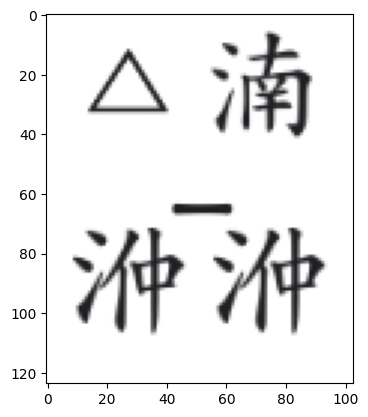

In [5]:
jng_synth = JeongganSynthesizer(note_paths)

jng_label, jng_img = jng_synth()

plt.imshow(jng_img, interpolation=None)
jng_label

태:10 배응:14 -:15


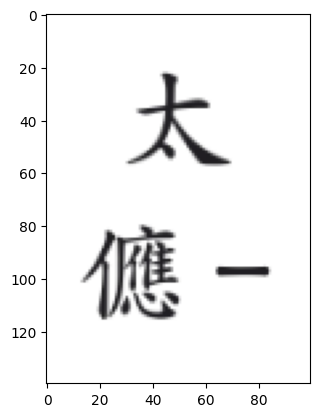

In [7]:
jng_synth = JeongganSynthesizer(note_paths)

_, label = jng_synth.get_label_dict()
print(label)

jng_img = jng_synth.generate_image_by_label(label)

plt.imshow(jng_img, interpolation=None)

  0%|          | 0/1000000 [00:00<?, ?it/s]

100%|██████████| 1000000/1000000 [00:12<00:00, 77938.47it/s]


<BarContainer object of 15 artists>

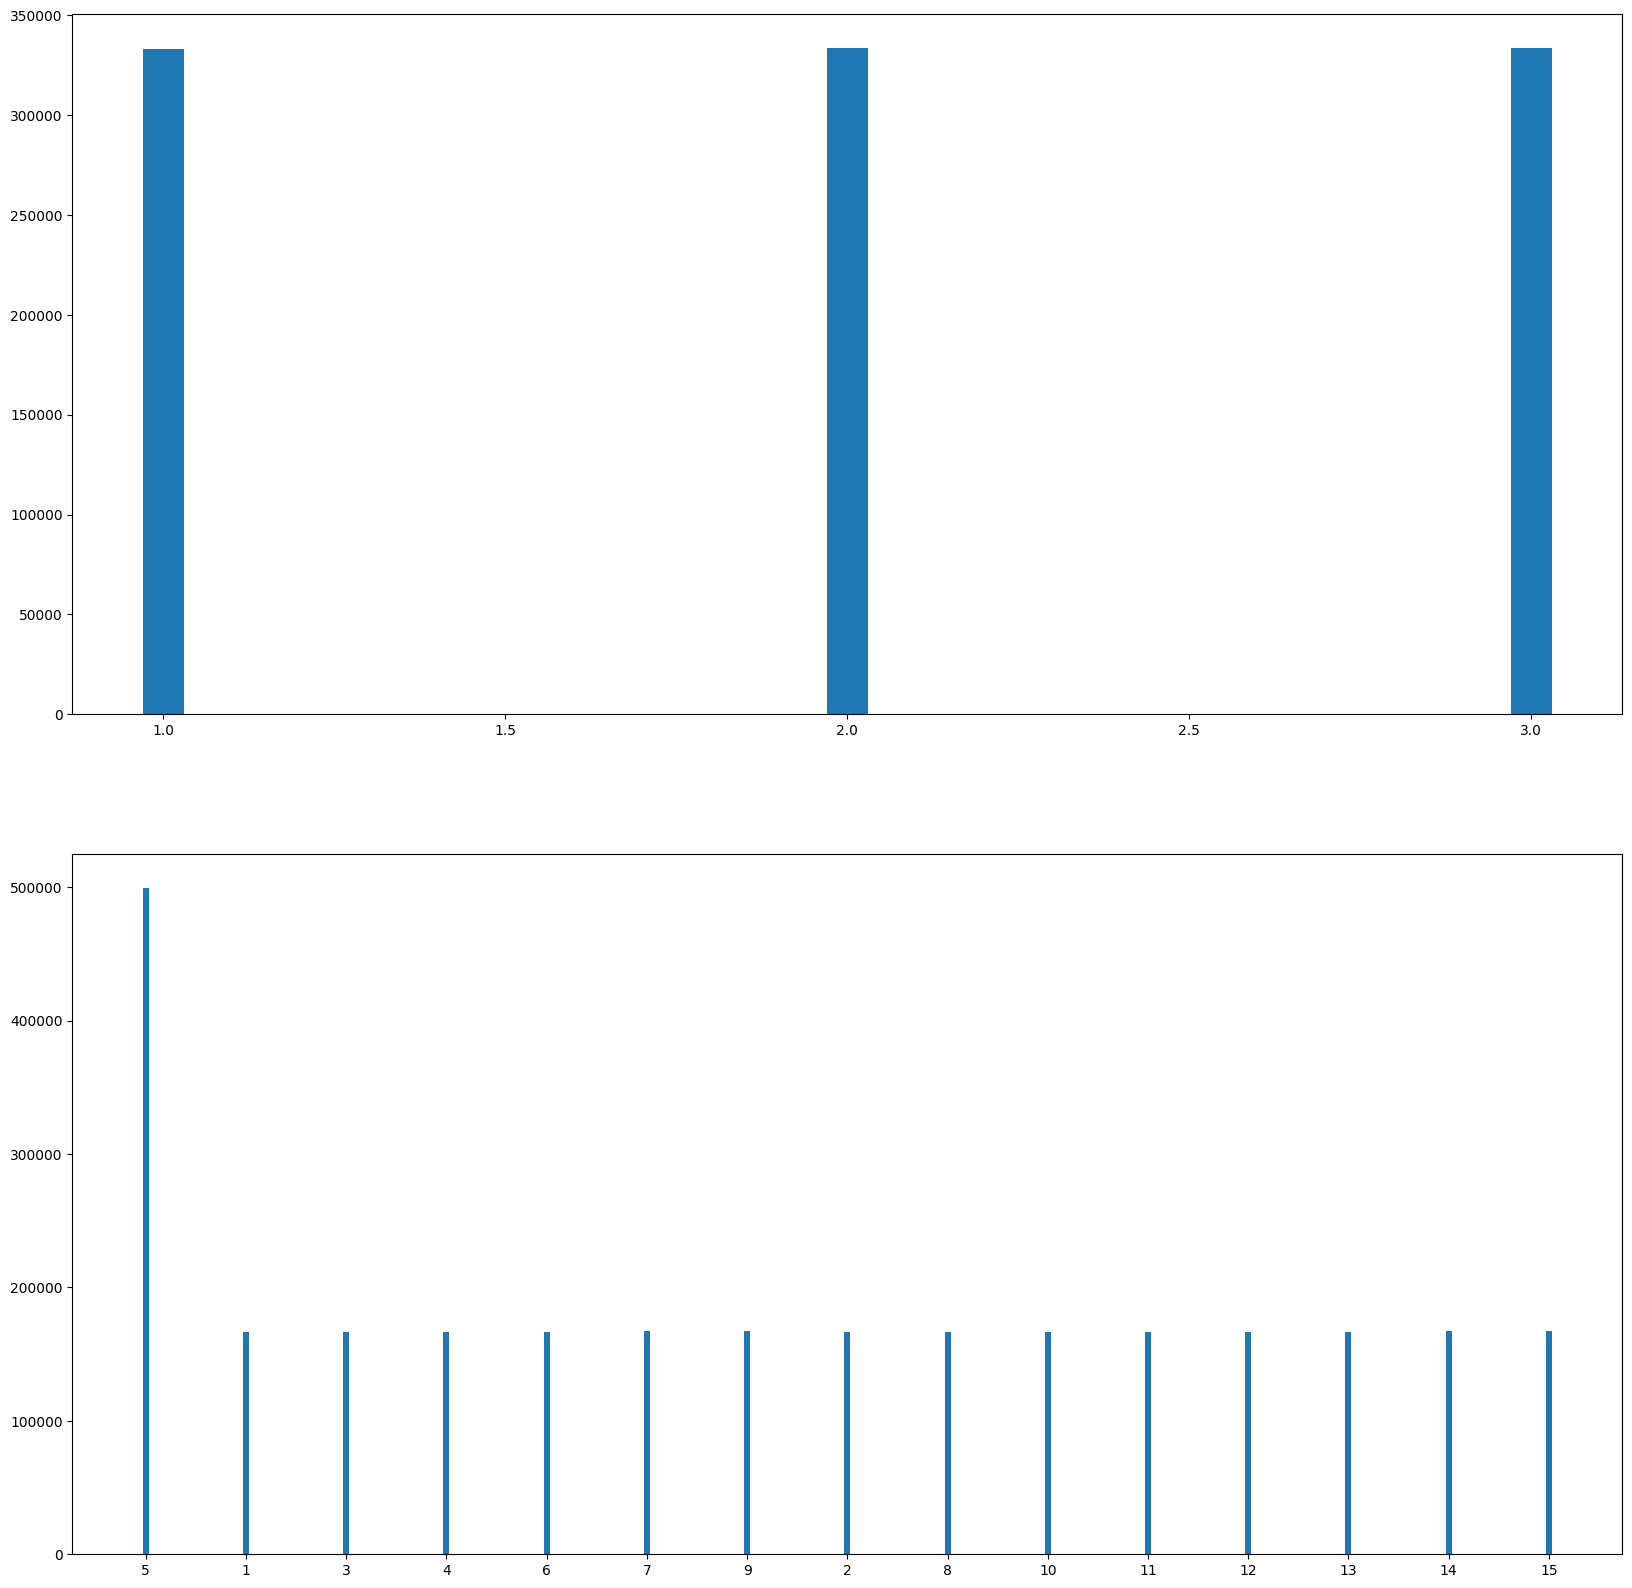

In [229]:
from collections import Counter

positions = []
row_divs = []

for _ in tqdm(range(1_000_000)):
  _, label = JeongganSynthesizer.get_label_dict()
  
  pattern = r'([^_\s:]+|_+[^_\s:]+|[^:]\d+|[-])'
    
  notes = label.split()
  
  poses = []
  
  for note in notes:
    findings = re.findall(pattern, note)
    poses.append( findings[-1] )
  
  row_div = JeongganProcessor.get_row_div( list( map(int, poses) ) )
  
  row_divs.append(row_div)
  positions += poses

row_div_cnt = Counter(row_divs)
position_cnt = Counter(positions)

plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.bar(row_div_cnt.keys(), row_div_cnt.values(), 0.06)

plt.subplot(2, 1, 2)
plt.bar(position_cnt.keys(), position_cnt.values(), 0.06)

## num of possible JNG combinations

In [183]:
from exp_utils import PITCH_ORDER, OCTAVE_WIDTH

num_marks = 2
num_octave_range = len(PITCH_ORDER) - OCTAVE_WIDTH
num_choices = OCTAVE_WIDTH + num_marks

num_col_variants = num_choices + pow(num_choices, 2)

num_octave_range * ( num_choices + pow(num_col_variants, 2) + pow(num_col_variants, 3) )

137547504

## train set (synth)

* JeongganSynthesizer.generate_single_data() takes 0.0006 sec
* 0.0006 * 1,000,000 = 600 (10min)
* average 3.1% fail rate

In [285]:
from time import time

NUM_RECIPE = 1_000_000

fail_cnt = 0

with open(f'test/data/train/002_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
    
  for _ in tqdm(range(NUM_RECIPE)):
    
    while True:
      try:
        label, width, height = jng_synth.generate_single_data()
        writer.writerow([label, width, height])
        break
      
      except:
        fail_cnt += 1

fail_cnt

100%|██████████| 1000000/1000000 [09:21<00:00, 1781.08it/s]


31922

## validation set (synth)

In [8]:
from time import time

NUM_RECIPE = 1_000

fail_cnt = 0

with open(f'test/data/valid/002_{int(time())}.csv', 'w', newline='', encoding='utf-8') as f:
  writer = csv.writer(f)
    
  for _ in tqdm(range(NUM_RECIPE)):
    
    while True:
      try:
        label, width, height = jng_synth.generate_single_data()
        writer.writerow([label, width, height])
        break
      
      except:
        fail_cnt += 1

fail_cnt

100%|██████████| 1000/1000 [00:00<00:00, 1767.00it/s]


32

## dataset test

In [16]:
train_data_filenames = ['001_1706859356', '002_1706860394']
valid_data_filenames = ['001_1706861315', '002_1706941333']

train_data_list = []

for data_filename in train_data_filenames:
  with open(f'test/data/train/{data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    train_data_list.append(list(reader))

valid_data_list = []
for data_filename in valid_data_filenames:
  with open(f'test/data/valid/{data_filename}.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    valid_data_list.append((reader))

### duplications in train data
* about 40% in single csv

In [33]:
train_data_list = [ list(map(tuple, train_data ) )for train_data in train_data_list ]

for idx, train_data in enumerate(train_data_list):
  print(idx+1, len(train_data) == len(set(train_data)), len(set(train_data)))

1 False 606471
2 False 606275


### duplication counts between train and valid set
**average 43%**

* t-1 and v-1: 460
* t-1 and v-2: 413
* t-2 and v-1: 457
* t-2 and v-2: 422

In [35]:
res = []

for valid_data in valid_data_list:
  dup_list = []
  for train_data in train_data_list:
    dup_cnt = 0
    for data in valid_data:
      data = tuple(data)
      if data in train_data:
        dup_cnt += 1
    
    dup_list.append(dup_cnt)
  
  res.append(dup_list)

res

[[460, 457], [413, 422]]

### image generation from recipe

('하배중:12 쉼표:13 하배황:14 하배황:15', '206', '103', (206, 103))

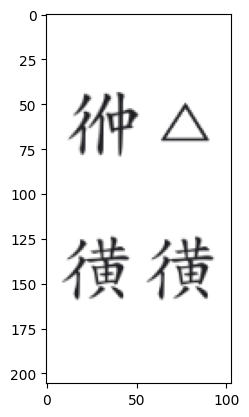

In [14]:
label, width, height = label_list[78]
jng_img = jng_synth.generate_image_by_label(label, int(width), int(height))

plt.imshow(jng_img)

label, height, width, jng_img.shape[:2]

## validation set (HL)

## test set (HL)